# ICT Project: Communication Services and Security
## Assignment 2

### Albert Pérez Datsira

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
header = ['Event_Type', 'Time', 'Link_Source_Node', 'Link_Destination_Node', 'Segment_Type', 'Segment_Size', 'Flags', 'Flow_Identifier', 'Segment_Source_Address', 'Segment_Destination_Address', 'Segment_Number', 'Segment_Identifier']

df = pd.read_csv('sim-trace.tr', sep=' ', names = header)

df.head()

,Event_Type,Time,Link_Source_Node,Link_Destination_Node,Segment_Type,Segment_Size,Flags,Flow_Identifier,Segment_Source_Address,Segment_Destination_Address,Segment_Number,Segment_Identifier
0,+,0.0,1,3,tcp,40,-------,1,1.0,4.1,0,0
1,-,0.0,1,3,tcp,40,-------,1,1.0,4.1,0,0
2,+,0.0,0,3,tcp,40,-------,0,0.0,4.0,0,1
3,-,0.0,0,3,tcp,40,-------,0,0.0,4.0,0,1
4,+,0.0,2,3,tcp,1000,-------,2,2.0,4.2,0,2


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28509 entries, 0 to 28508
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Event_Type                   28509 non-null  object 
 1   Time                         28509 non-null  float64
 2   Link_Source_Node             28509 non-null  int64  
 3   Link_Destination_Node        28509 non-null  int64  
 4   Segment_Type                 28509 non-null  object 
 5   Segment_Size                 28509 non-null  int64  
 6   Flags                        28509 non-null  object 
 7   Flow_Identifier              28509 non-null  int64  
 8   Segment_Source_Address       28509 non-null  float64
 9   Segment_Destination_Address  28509 non-null  float64
 10  Segment_Number               28509 non-null  int64  
 11  Segment_Identifier           28509 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 2.6+ MB


### Lost Packets

In [4]:
lost_packages = df.Event_Type == 'd'
ids = df[lost_packages].Segment_Source_Address

n0_lost = ids == 0 #TCP Vegas
n1_lost = ids == 1 #TCP Reno
n2_lost = ids == 2 #TCP Tahoe

In [5]:
print("Lost Packages")
print("Node 0:\t", sum(n0_lost))
print("Node 1:\t", sum(n1_lost))
print("Node 2:\t", sum(n2_lost))
print("Total:\t", ids.count())

Lost Packages
Node 0:	 10
Node 1:	 11
Node 2:	 1
Total:	 22


### Transferred bytes

In [6]:
def getNode(row, node):
  return row.Link_Source_Node == int(node) and row.Event_Type == '-'
n0_packets = df.apply(getNode, axis = 1, args=('0'))
n1_packets = df.apply(getNode, axis = 1, args=('1'))
n2_packets = df.apply(getNode, axis = 1, args=('2'))
n3_packets = df.apply(getNode, axis = 1, args=('3'))
n4_packets = df.apply(getNode, axis = 1, args=('4'))

n0_bytes = sum(df[n0_packets].Segment_Size)
n1_bytes = sum(df[n1_packets].Segment_Size)
n2_bytes = sum(df[n2_packets].Segment_Size)
n3_bytes = sum(df[n3_packets].Segment_Size)
n4_bytes = sum(df[n4_packets].Segment_Size)
total_bytes = n0_bytes + n1_bytes + n2_bytes + n3_bytes + n4_bytes

In [7]:
print("Transferred bytes:")
print("Node 0:\t", n0_bytes)
print("Node 1:\t", n1_bytes)
print("Node 2:\t", n2_bytes)
print("Node 3:\t", n3_bytes)
print("Node 4:\t", n4_bytes)
print("Total:\t", total_bytes)

Transferred bytes:
Node 0:	 765480
Node 1:	 759240
Node 2:	 940000
Node 3:	 2516560
Node 4:	 94400
Total:	 5075680


## sim-trace.rtt

In [8]:
header2 = ['Node', 'Time', 'rtt', 'srtt', 'cwnd', 'cwmax', 'bo']

df2 = pd.read_csv('sim-trace.rtt', sep=' ', names = header2)

df2.head()

,Node,Time,rtt,srtt,cwnd,cwmax,bo
0,0,0.0,0.0,0.0,1.0,40,0.0
1,1,0.0,0.0,0.0,1.0,40,0.0
2,2,0.0,0.0,0.0,1.0,40,0.0
3,0,0.1,0.0,0.0,1.0,40,0.0
4,1,0.1,0.0,0.0,1.0,40,0.0


In [9]:
time = df2[df2.Node==0].Time
cwnd0 = df2[df2.Node==0].cwnd
cwnd1 = df2[df2.Node==1].cwnd
cwnd2 = df2[df2.Node==2].cwnd

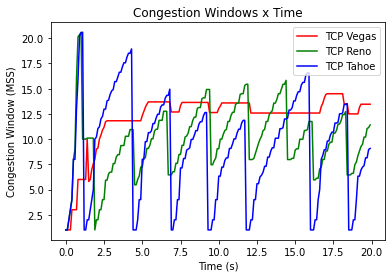

In [10]:
plt.plot(time,cwnd2, label='TCP Vegas', color='red')
plt.plot(time,cwnd1, label='TCP Reno', color='green')
plt.plot(time,cwnd0, label='TCP Tahoe', color='blue')

plt.title('Congestion Windows x Time')
plt.xlabel('Time (s)')
plt.ylabel('Congestion Window (MSS)')
plt.legend(loc='upper right')
plt.show()